In this assignment, we'll be looking at the Housing Prices dataset. In short, we'll be predicting housing prices. In detail, here's what I'll be doing:


*   Load the dataset.
*   Investigate the data, and do any necessary data cleaning.
*   Explore the data and find some variables that I think would be useful in predicting house prices.
*   Build an initial model using these features and estimate the parameters using OLS.





In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')


postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
houseprices_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


In [3]:
houseprices_df.shape

(1460, 81)

In [4]:
houseprices_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,...,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000



Data is loaded. We already know the target variable is the sales price. Let's take a look at its distribution:

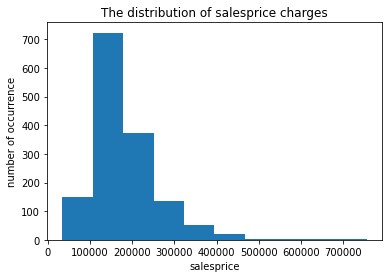

In [5]:
plt.hist(houseprices_df.saleprice)
plt.title("The distribution of salesprice charges")
plt.xlabel("salesprice")
plt.ylabel("number of occurrence")
plt.show()



In [6]:
houseprices_df.isnull().sum()*100/houseprices_df.isnull().count()

id                0.000000
mssubclass        0.000000
mszoning          0.000000
lotfrontage      17.739726
lotarea           0.000000
                   ...    
mosold            0.000000
yrsold            0.000000
saletype          0.000000
salecondition     0.000000
saleprice         0.000000
Length: 81, dtype: float64


We have 19 features with missing values, most of which are housing extras that may not significantly correlate with SalePrice. Let's draw a correlation table to be sure.

In [7]:
houseprices_df.corr().sort_values(by='saleprice',ascending=False)

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
saleprice,-0.021917,-0.084284,0.351799,0.263843,0.790982,-0.077856,0.522897,0.507101,0.477493,0.386420,-0.011378,0.214479,0.613581,0.605852,0.319334,-0.025606,0.708624,0.227122,-0.016844,0.560664,0.284108,0.168213,-0.135907,0.533723,0.466929,0.486362,0.640409,0.623431,0.324413,0.315856,-0.128578,0.044584,0.111447,0.092404,-0.021190,0.046432,-0.028923,1.000000
overallqual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,0.308159,0.537808,0.476224,0.295493,-0.030429,0.593007,0.111098,-0.040150,0.550600,0.273458,0.101676,-0.183882,0.427452,0.396765,0.547766,0.600671,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
grlivarea,0.008273,0.074853,0.402797,0.263116,0.593007,-0.079686,0.199010,0.287389,0.390857,0.208171,-0.009640,0.240257,0.454868,0.566024,0.687501,0.134683,1.000000,0.034836,-0.018918,0.630012,0.415772,0.521270,0.100063,0.825489,0.461679,0.231197,0.467247,0.468997,0.247433,0.330224,0.009113,0.020643,0.101510,0.170205,-0.002416,0.050240,-0.036526,0.708624
garagecars,0.016570,-0.040110,0.285691,0.154871,0.600671,-0.185758,0.537850,0.420622,0.364204,0.224054,-0.038264,0.214175,0.434585,0.439317,0.183926,-0.094480,0.467247,0.131881,-0.020891,0.469672,0.219178,0.086106,-0.050634,0.362289,0.300789,0.588920,1.000000,0.882475,0.226342,0.213569,-0.151434,0.035765,0.050494,0.020934,-0.043080,0.040522,-0.039117,0.640409
garagearea,0.017634,-0.098672,0.344997,0.180403,0.562022,-0.151521,0.478954,0.371600,0.373066,0.296970,-0.018227,0.183303,0.486665,0.489782,0.138347,-0.067601,0.468997,0.179189,-0.024536,0.405656,0.163549,0.065253,-0.064433,0.337822,0.269141,0.564567,0.882475,1.000000,0.224666,0.241435,-0.121777,0.035087,0.051412,0.061047,-0.027400,0.027974,-0.027378,0.623431
totalbsmtsf,-0.015415,-0.238518,0.392075,0.260833,0.537808,-0.171098,0.391452,0.291066,0.363936,0.522396,0.104810,0.415360,1.000000,0.819530,-0.174512,-0.033245,0.454868,0.307351,-0.000315,0.323722,-0.048804,0.050450,-0.068901,0.285573,0.339519,0.322445,0.434585,0.486665,0.232019,0.247264,-0.095478,0.037384,0.084489,0.126053,-0.018479,0.013196,-0.014969,0.613581
firstflrsf,0.010496,-0.251758,0.457181,0.299475,0.476224,-0.144203,0.281986,0.240379,0.344501,0.445863,0.097117,0.317987,0.819530,1.000000,-0.202646,-0.014241,0.566024,0.244671,0.001956,0.380637,-0.119916,0.127401,0.068101,0.409516,0.410531,0.233449,0.439317,0.489782,0.235459,0.211671,-0.065292,0.056104,0.088758,0.131525,-0.021096,0.031372,-0.013604,0.605852
fullbath,0.005587,0.131608,0.198769,0.126031,0.550600,-0.194149,0.468271,0.439046,0.276833,0.058543,-0.076444,0.288886,0.323722,0.380637,0.421378,-0.000710,0.630012,-0.064512,-0.054536,1.000000,0.136381,0.363252,0.133115,0.554784,0.243671,0.484557,0.469672,0.405656,0.187703,0.259977,-0.115093,0.035353,-0.008106,0.049604,-0.014290,0.055872,-0.019669,0.560664
totrmsabvgrd,0.027239,0.040380,0.352096,0.190015,0.427452,-0.057583,0.095589,0.191740,0.280682,0.044316,-0.035227,0.250647,0.285573,0.409516,0.616423,0.131185,0.825489,-0.053275,-0.023836,0.554784,0.343415,0.676620,0.256045,1.000000,0.326114,0.148112,0.362289,0.337822,0.165984,0.234192,0.004151,-0.006683,0.059383,0.083757,0.024763,0.036907,-0.034516,0.533723
yearbuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,0.149040,0.391452,0.281986,0.010308,-0.183784,0.199010,0.187599,-0.038162,0.468271,0.242656,-0.070651,-0.174800,0.095589,0.147716,0.825667,0.537850,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.0343

We are initially interested in the first 11 features (the ones with more than 50% correlation with SalePrice). However, since houses tend to have many features that correlate with each other, let's draw a heatmap and pick out the features that are correlated with each other:

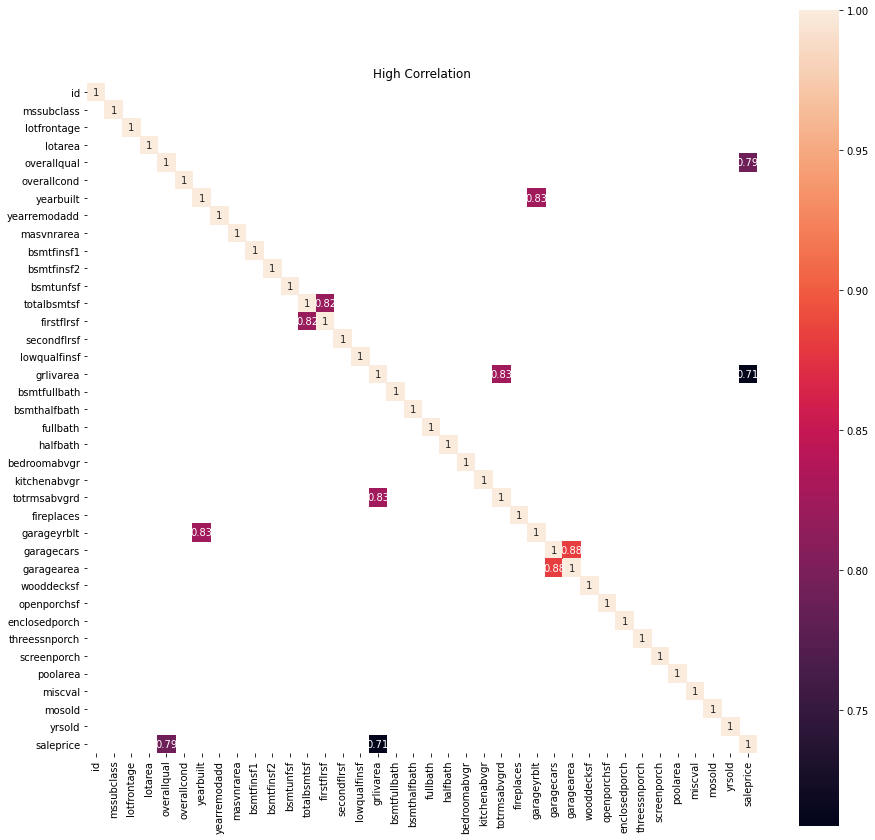

In [8]:
num_correlation = houseprices_df.corr()
correlation = num_correlation[num_correlation > .7]
plt.figure(figsize=(15,15))
plt.title('High Correlation')
sns.heatmap(correlation ,square=True, annot=True)

We can notice that yearbuilt strongly correlates with garageyrblt, due to usually building houses with garages included. Also, totrmsabvgrd (total rooms above ground) correlates with grlivarea.

In [40]:
#corr = num_correlation.corr()
#corr[corr['saleprice']>0.7].index

In [34]:
houseprices_df = houseprices_df[['overallqual', 'yearbuilt', 'yearremodadd', 'totalbsmtsf',
       'firstflrsf', 'grlivarea', 'fullbath', 'fireplaces','garagecars', 'garagearea', 'saleprice']]

How do these features look against the target?

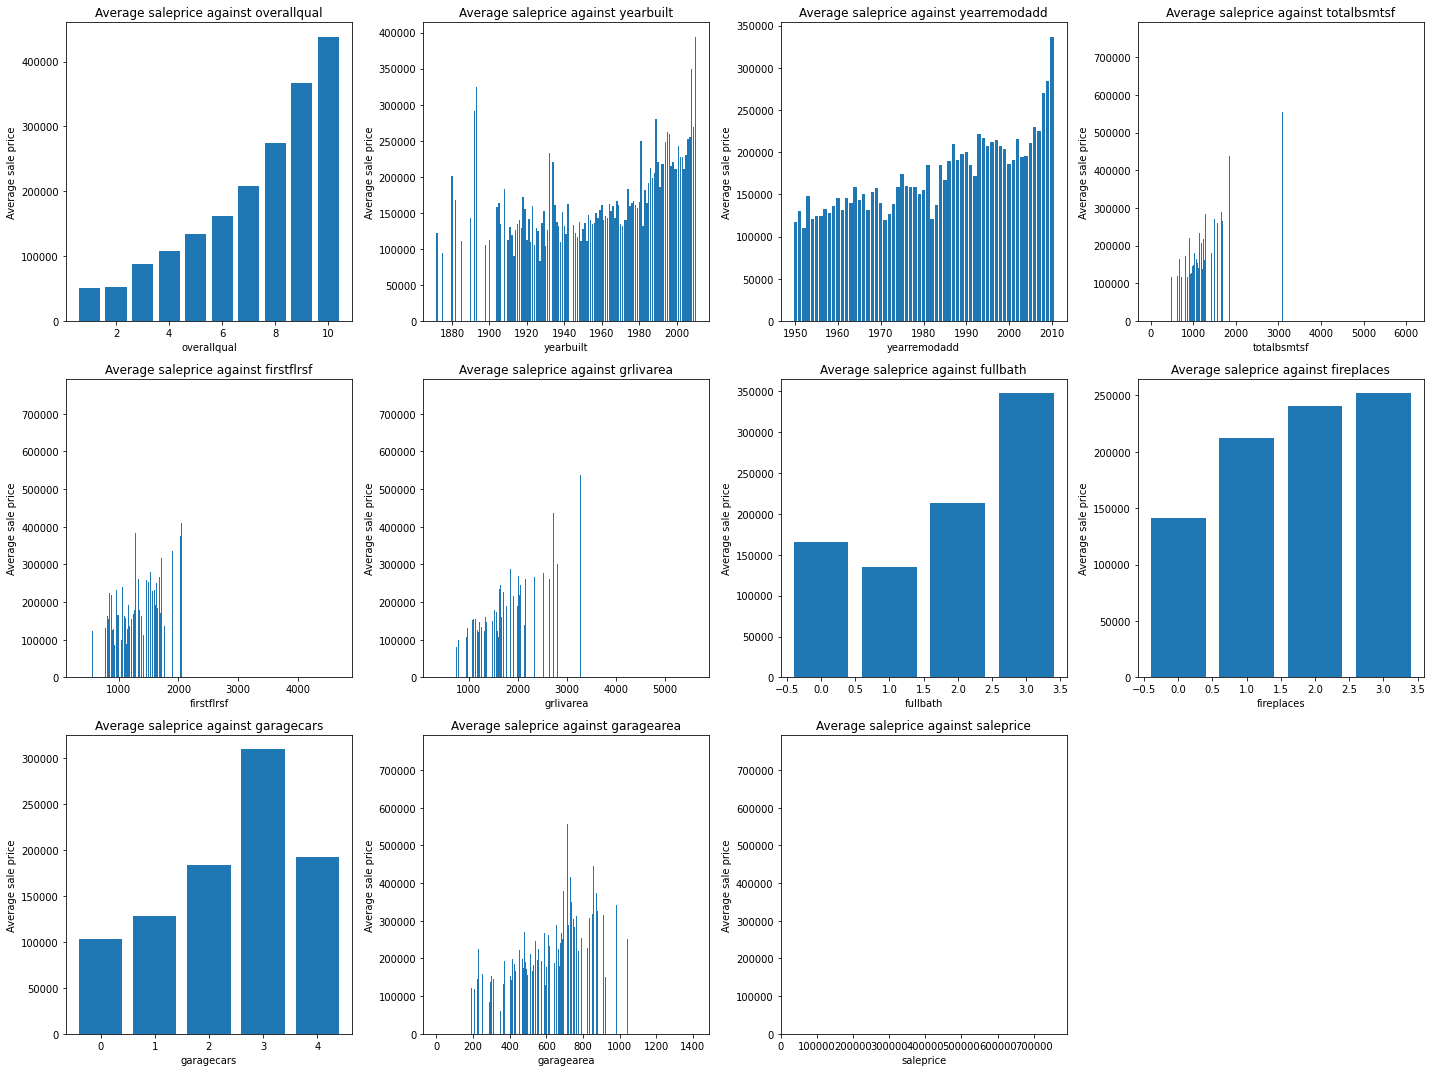

In [35]:
columns = ['overallqual', 'yearbuilt', 'yearremodadd', 'totalbsmtsf',
       'firstflrsf', 'grlivarea', 'fullbath', 'fireplaces','garagecars', 'garagearea', 'saleprice']
plt.figure(figsize = (20, 15))
i = 0
for column in columns:
  i +=1
  plt.tight_layout()
  plt.subplot(3, 4, i)
  plt.bar(houseprices_df.groupby(column)['saleprice'].mean().index, houseprices_df.groupby(column)['saleprice'].mean())
  plt.title("Average saleprice against {}".format(column))
  plt.ylabel("Average sale price")
  plt.xlabel(column)


We can see clear trends as each of these variables increase in value, this is due to a significant positive correlation with the target variable.

Now we move to check the type of data in each of these variables:

In [36]:
houseprices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   overallqual   1460 non-null   int64
 1   yearbuilt     1460 non-null   int64
 2   yearremodadd  1460 non-null   int64
 3   totalbsmtsf   1460 non-null   int64
 4   firstflrsf    1460 non-null   int64
 5   grlivarea     1460 non-null   int64
 6   fullbath      1460 non-null   int64
 7   fireplaces    1460 non-null   int64
 8   garagecars    1460 non-null   int64
 9   garagearea    1460 non-null   int64
 10  saleprice     1460 non-null   int64
dtypes: int64(11)
memory usage: 125.6 KB


All of these variables are integers. Therefore no onehot encoding needed. Let's proceed to create our regression model:

In [37]:
features = list(houseprices_df.columns)
features.remove('saleprice')

X = houseprices_df[features]
Y = houseprices_df['saleprice']


X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     508.3
Date:                Fri, 17 Jul 2020   Prob (F-statistic):               0.00
Time:                        20:23:57   Log-Likelihood:                -17445.
No. Observations:                1460   AIC:                         3.491e+04
Df Residuals:                    1449   BIC:                         3.497e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -1.24e+06   1.27e+05     -9.725      0.000   -1.49e+06    -9.9e+05
overallqual   1.852e+04   1193.104     15.524      0.000    1.62e+04    2.09e+04
yearbuilt      263.8420     49.689      5.310      0.000     166.372     361.312
yearremodadd   331.8867     63.325      5.241      0.000     207.669     456.104
totalbsmtsf     20.6463      4.244      4.864      0.000      12.320      28.972
firstflrsf      10.2334      4.935      2.074      0.038       0.554      19.913
grlivarea       47.5010      3.160     15.032      0.000      41.302      53.700
fullbath     -5198.1908   2648.182     -1.963      0.050   -1.04e+04      -3.510
fireplaces    9776.1372   1806.881      5.411      0.000    6231.754    1.33e+04
garagecars    8764.2326   3019.149      2.903      0.004    2841.863    1.47e+04
garagearea      20.5860     10.238      2.011      0.045       0.504      40.668
==============================================================================
Omnibus:                      466.155   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            62050.313
Skew:                          -0.313   Prob(JB):                         0.00
Kurtosis:                      34.931   Cond. No.                     4.68e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.68e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""